/tmp/ipykernel_1154498/3392693899.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  orders['order_month'] = orders['created_at'].dt.to_period('M')
/tmp/ipykernel_1154498/3392693899.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  orders['cohort_month'] = orders.groupby('customer_id')['created_at'].transform('min').dt.to_period('M')


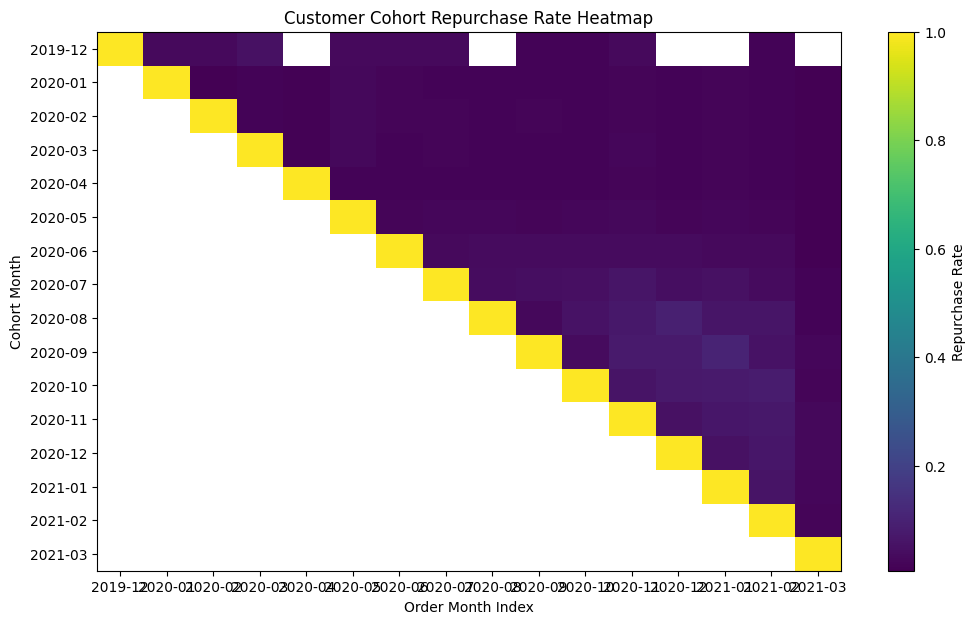

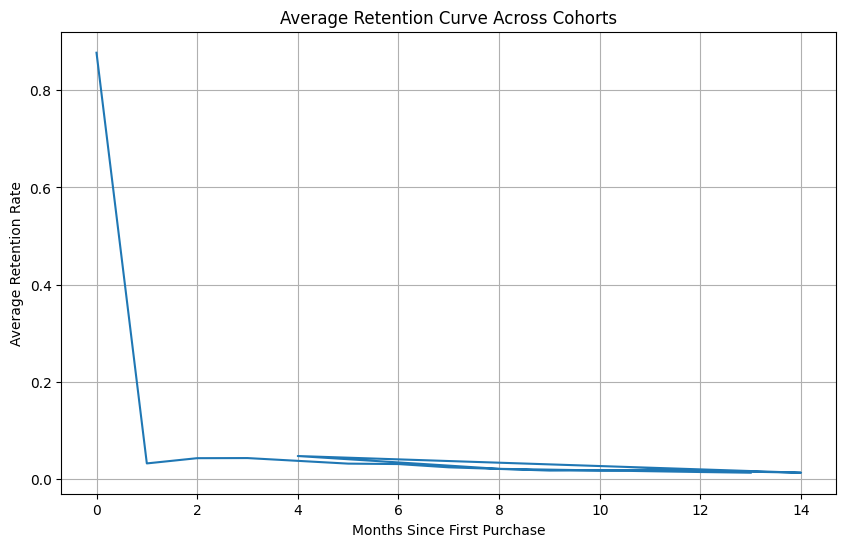

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
orders = pd.read_csv('/home/mamunds/job/pyspark/everdrop_data_analyst_case_study/orders_data.csv')
orders['created_at'] = pd.to_datetime(orders['created_at'])

# Cohort and order month
orders['order_month'] = orders['created_at'].dt.to_period('M')
orders['cohort_month'] = orders.groupby('customer_id')['created_at'].transform('min').dt.to_period('M')

# Cohort sizes
cohort_sizes = orders.groupby('cohort_month')['customer_id'].nunique()

# Purchases per cohort/month
cohort = orders.groupby(['cohort_month','order_month'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort.pivot(index='cohort_month', columns='order_month', values='customer_id')

# Repurchase rate
repurchase_rate = cohort_pivot.div(cohort_sizes, axis=0)

# Plot heatmap
plt.figure(figsize=(12,7))
plt.imshow(repurchase_rate, aspect='auto')
plt.colorbar(label="Repurchase Rate")
plt.title("Customer Cohort Repurchase Rate Heatmap")
plt.xlabel("Order Month Index")
plt.ylabel("Cohort Month")
plt.xticks(ticks=np.arange(len(repurchase_rate.columns)), labels=[str(c) for c in repurchase_rate.columns])
plt.yticks(ticks=np.arange(len(repurchase_rate.index)), labels=[str(i) for i in repurchase_rate.index])
plt.show()

# Build month-index retention curve
rate_numeric = pd.DataFrame()
for cohort_month in repurchase_rate.index:
    row = repurchase_rate.loc[cohort_month].dropna()
    indexed_vals = []
    for m in row.index:
        idx = (m.to_timestamp() - cohort_month.to_timestamp()).days // 30
        indexed_vals.append((idx, row[m]))
    for idx, val in indexed_vals:
        rate_numeric.loc[cohort_month, idx] = val

avg_retention = rate_numeric.mean()

plt.figure(figsize=(10,6))
plt.plot(avg_retention.index, avg_retention.values)
plt.title("Average Retention Curve Across Cohorts")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Average Retention Rate")
plt.grid(True)
plt.show()
